In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import keras
from keras import layers
import os
import matplotlib.pyplot as plt
#from imblearn.under_sampling import RandomUnderSampler
#from tabulate import tabulate
from itertools import islice
from scipy.signal import resample
from sklearn.preprocessing import StandardScaler
import pickle
import glob
import random
#import dask.dataframe as dd

In [6]:
data_path = '/content/drive/MyDrive/MovePort/'
#Modified_Df_PATH = '/content/drive/MyDrive/MovePortModif/'
participants = sorted([p for p in os.listdir(data_path) if p.isdigit()], key=int)
print("Participants disponibles :", participants)
activities = ['back', 'forward', 'halfsquat', 'still']
modalities = ['ips_1', 'emg_1', 'imu_1', 'cop_1']

Participants disponibles : ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25']


In [22]:
def list_missing_files(base_path, participants, activities, modalities):
  missing_files = {}
  for participant in participants:
    participant_missing = {}
    for activity in activities:
      for modality in modalities:
        file_path = os.path.join(base_path, str(participant), activity, f"{modality}.csv")
        if not os.path.exists(file_path):
          if activity not in participant_missing:
            participant_missing[activity] = []
          participant_missing[activity].append(modality)
    if participant_missing:
      missing_files[participant] = participant_missing
  return missing_files

In [23]:
# Lister les fichiers manquants
missing_files = list_missing_files(data_path, participants, activities, modalities)
# Afficher les résultats
participants_manque_files = []
print("Participants avec des fichiers de modalités manquants :")
for participant, activities in missing_files.items():
    print(f"Participant {participant}:")
    participants_manque_files.append(participant)
    for activity, modalities in activities.items():
        print(f"  Activité {activity}: Modalités manquantes: {', '.join(modalities)}")

Participants avec des fichiers de modalités manquants :
Participant 18:
  Activité forward: Modalités manquantes: ips_1, emg_1, imu_1, cop_1, mocap_1
Participant 19:
  Activité forward: Modalités manquantes: ips_1, emg_1, imu_1, cop_1, mocap_1
Participant 20:
  Activité forward: Modalités manquantes: ips_1, emg_1, imu_1, cop_1, mocap_1
Participant 21:
  Activité forward: Modalités manquantes: ips_1, emg_1, imu_1, cop_1, mocap_1
Participant 22:
  Activité back: Modalités manquantes: ips_1, emg_1, imu_1, cop_1, mocap_1
Participant 23:
  Activité forward: Modalités manquantes: ips_1, emg_1, imu_1, cop_1, mocap_1
  Activité halfsquat: Modalités manquantes: ips_1, emg_1, imu_1, cop_1, mocap_1
Participant 24:
  Activité halfsquat: Modalités manquantes: ips_1, emg_1, imu_1, cop_1, mocap_1


In [ ]:
#participants_manque_files

In [ ]:
"""def get_column_structure_and_shape(base_path, participants, activities, modalities):

  column_structure = {}
  data_shapes = {}
  for modality in modalities:
      for participant in participants:
          for activity in activities:
              file_path = os.path.join(base_path, str(participant), activity, f"{modality}.csv")
              if os.path.exists(file_path):
                  df = pd.read_csv(file_path, header=0)
                  column_structure[modality] = df.columns
                  data_shapes[modality] = df.shape
                  break
          if modality in column_structure:
              break
      if modality not in column_structure:
          raise ValueError(f"Structure des colonnes introuvable pour la modalité {modality}")

  return column_structure, data_shapes"""

'def get_column_structure_and_shape(base_path, participants, activities, modalities):\n\n  column_structure = {}\n  data_shapes = {}\n  for modality in modalities:\n      for participant in participants:\n          for activity in activities:\n              file_path = os.path.join(base_path, str(participant), activity, f"{modality}.csv")\n              if os.path.exists(file_path):\n                  df = pd.read_csv(file_path, header=0)\n                  column_structure[modality] = df.columns\n                  data_shapes[modality] = df.shape\n                  break\n          if modality in column_structure:\n              break\n      if modality not in column_structure:\n          raise ValueError(f"Structure des colonnes introuvable pour la modalité {modality}")\n\n  return column_structure, data_shapes'

In [ ]:
"""def calculate_mean_structure(base_path, participants, activities, modalities):

  mean_data = {modality: [] for modality in modalities}
  for activity in activities:
      for modality in modalities:
          participant_pairs = random.sample(participants, 2)
          modality_data = []
          for participant in participant_pairs:
              file_path = os.path.join(base_path, str(participant), activity, f"{modality}.csv")
              if os.path.exists(file_path):
                  try:
                      df = pd.read_csv(file_path, header=0)
                      numeric_df = df.apply(pd.to_numeric, errors='coerce')  # Convertir en numérique
                      modality_data.append(numeric_df)
                  except Exception as e:
                      print(f"Erreur lors du chargement de {file_path}: {e}")
          if modality_data:
              combined_df = pd.concat(modality_data)
              combined_df = combined_df.apply(pd.to_numeric, errors='coerce')
              combined_df = combined_df.dropna(axis=1, how='all')  # Supprimer les colonnes entièrement non numériques
              mean_df = combined_df.mean(axis=0).to_frame().transpose()  # Calculer uniquement les colonnes numériques
              mean_df = round(mean_df, 3)
              mean_data[modality].append(mean_df)

  for modality in modalities:
      mean_data[modality] = pd.concat(mean_data[modality], axis=0).mean(axis=0).to_frame().transpose()

  return mean_data"""

'def calculate_mean_structure(base_path, participants, activities, modalities):\n\n  mean_data = {modality: [] for modality in modalities}\n  for activity in activities:\n      for modality in modalities:\n          participant_pairs = random.sample(participants, 2)\n          modality_data = []\n          for participant in participant_pairs:\n              file_path = os.path.join(base_path, str(participant), activity, f"{modality}.csv")\n              if os.path.exists(file_path):\n                  try:\n                      df = pd.read_csv(file_path, header=0)\n                      numeric_df = df.apply(pd.to_numeric, errors=\'coerce\')  # Convertir en numérique\n                      modality_data.append(numeric_df)\n                  except Exception as e:\n                      print(f"Erreur lors du chargement de {file_path}: {e}")\n          if modality_data:\n              combined_df = pd.concat(modality_data)\n              combined_df = combined_df.apply(pd.to_numeric,

In [ ]:
"""def create_missing_files_with_mean(base_path, participant_id, activities, modalities, mean_data, column_structure, data_shapes):

  participant_path = os.path.join(base_path, str(participant_id))
  for activity in activities:
      activity_path = os.path.join(participant_path, activity)
      if not os.path.exists(activity_path):
          os.makedirs(activity_path)  # Crée le dossier d'activité s'il n'existe pas
      for modality in modalities:
          file_path = os.path.join(activity_path, f"{modality}.csv")
          if not os.path.exists(file_path):
              print(f"Création de {file_path} avec des données moyennes et structure correcte")
              shape = data_shapes[modality]
              synthetic_data = pd.DataFrame(np.tile(mean_data[modality].values, (shape[0], 1)), columns=mean_data[modality].columns)
              synthetic_data = synthetic_data.reindex(columns=column_structure[modality], fill_value=0)  # Alignement des colonnes
              synthetic_data.to_csv(file_path, index=False)"""

'def create_missing_files_with_mean(base_path, participant_id, activities, modalities, mean_data, column_structure, data_shapes):\n\n  participant_path = os.path.join(base_path, str(participant_id))\n  for activity in activities:\n      activity_path = os.path.join(participant_path, activity)\n      if not os.path.exists(activity_path):\n          os.makedirs(activity_path)  # Crée le dossier d\'activité s\'il n\'existe pas\n      for modality in modalities:\n          file_path = os.path.join(activity_path, f"{modality}.csv")\n          if not os.path.exists(file_path):\n              print(f"Création de {file_path} avec des données moyennes et structure correcte")\n              shape = data_shapes[modality]\n              synthetic_data = pd.DataFrame(np.tile(mean_data[modality].values, (shape[0], 1)), columns=mean_data[modality].columns)\n              synthetic_data = synthetic_data.reindex(columns=column_structure[modality], fill_value=0)  # Alignement des colonnes\n             

In [ ]:
# Calculer les moyennes à partir des participants 1 à 16
existing_participants = list(range(1, 17))

In [ ]:
# Créer les fichiers manquants pour chaque participant de la liste
#column_structure, data_shapes = get_column_structure_and_shape(data_path, existing_participants, activities, modalities)
#for participant_id in participants_manque_files:
    #mean_data = calculate_mean_structure(data_path, existing_participants, activities, modalities)
    #create_missing_files_with_mean(data_path, participant_id, activities, modalities, mean_data, column_structure, data_shapes)

print("Tous les dossiers et fichiers manquants ont été créés avec des valeurs moyennes et une structure correcte.")

Tous les dossiers et fichiers manquants ont été créés avec des valeurs moyennes et une structure correcte.


In [ ]:
"""newFileips = pd.read_csv('/content/drive/MyDrive/MovePort/18/forward/ips_1.csv')
newFileemg = pd.read_csv('/content/drive/MyDrive/MovePort/19/forward/emg_1.csv')
newFileimu = pd.read_csv('/content/drive/MyDrive/MovePort/21/forward/imu_1.csv')
print('shape of ips' ,newFileips.shape)
print('shape of emg' ,newFileemg.shape)
print('shape of imu' ,newFileimu.shape)"""

"newFileips = pd.read_csv('/content/drive/MyDrive/MovePort/18/forward/ips_1.csv')\nnewFileemg = pd.read_csv('/content/drive/MyDrive/MovePort/19/forward/emg_1.csv')\nnewFileimu = pd.read_csv('/content/drive/MyDrive/MovePort/21/forward/imu_1.csv')\nprint('shape of ips' ,newFileips.shape)\nprint('shape of emg' ,newFileemg.shape)\nprint('shape of imu' ,newFileimu.shape)"

In [ ]:
# justqu'au la c'est carré !

In [4]:
from sklearn.preprocessing import LabelEncoder
# Encoder les catégories
categories = ['back', 'forward', 'halfsquat', 'still']
category_encoder = LabelEncoder()
category_encoder.fit(categories)

LabelEncoder()

In [5]:
def decode_categories(df, column_name='categorie'):
  df[column_name] = category_encoder.inverse_transform(df[column_name])
  return df

In [6]:
def inverser_csv(file_path):
  df = pd.read_csv(file_path, header=0)
  df = df.transpose()
  df.columns = df.iloc[0]  # Première ligne devient l'en-tête
  #df.dropna(inplace=True)
  df = df[1:].reset_index(drop=True)  # Supprimer la première ligne et réindexer
  return df

In [7]:
def process_data_in_batch(participant_path, modality):
  # Dictionnaire pour mapper les catégories aux valeurs numériques manuellement
  # category_mapping = {'back': 0, 'forward': 1, 'halfsquat': 2, 'still': 3}
  all_category_data = []

  for category in categories:
    # Chercher les fichiers spécifiques à la modalité
    files = glob.glob(os.path.join(participant_path, category, f"{modality}_1.csv"))
    print(f"  Fichiers {modality.upper()} trouvés pour la catégorie '{category}': {files}")
    category_data = []  # Liste pour stocker les données de cette catégorie
    for file in files:
      print(f"    Traitement du fichier {modality.upper()} : {file}")
      try:
        df = inverser_csv(file)
        df['categorie'] = category_encoder.transform([category])[0]
        category_data.append(df)
      except Exception as e:
        print(f"Erreur lors du traitement du fichier {file}: {e}")
    # Concaténer toutes les données de la catégorie pour ce participant
    if category_data:
      concatenated_category_data = pd.concat(category_data, ignore_index=True)
      all_category_data.append(concatenated_category_data)
  # Retourner toutes les données des catégories pour ce participant
  if all_category_data:
    return pd.concat(all_category_data, ignore_index=True)
  else:
    return None

In [8]:
def process_participants(data_path, participants, modality, batch_size=5):

  all_data = []  # Liste pour stocker toutes les données traitées
  # Diviser les participants en lots (batchs)
  participants_batches = [participants[i:i + batch_size] for i in range(0, len(participants), batch_size)]

  for batch_idx, batch_participants in enumerate(participants_batches, start=1):
    print(f"Traitement du lot {batch_idx}/{len(participants_batches)} : Participants {batch_participants}")
    batch_data = []  # Liste pour stocker les données d'un batch
    for participant_id in batch_participants:
      participant_path = os.path.join(data_path, str(participant_id))
      # Traiter les données pour ce participant
      print(f"Participant {participant_id}")
      participant_data = process_data_in_batch(participant_path, modality)
      # Ajouter l'ID du participant aux données
      if participant_data is not None:
        participant_data['id'] = participant_id  # Ajouter l'ID du participant
        batch_data.append(participant_data)
    # Concaténer les données du lot
    if batch_data:
      batch_df = pd.concat(batch_data, ignore_index=True)
      all_data.append(batch_df)
  # Concaténer toutes les données traitées en un seul DataFrame
  if all_data:
    concatenated_data = pd.concat(all_data, ignore_index=True)
    return concatenated_data
  else:
    print("Aucune donnée valide trouvée.")
    return None

In [9]:
batch_size = 5  # regroupe les participants en 5
#participants = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
participants = participants

In [10]:
modalityImu = 'imu'  # Modalité, ici imu
modalityEmg = 'emg'  # Modalité, ici emg
modalityIps = 'ips'  # Modalité, ici ips
# Appel de la fonction pour traiter les données
processed_dataImu = process_participants(data_path, participants, modalityImu, batch_size)
processed_dataEmg = process_participants(data_path, participants, modalityEmg, batch_size)
processed_dataIps = process_participants(data_path, participants, modalityIps, batch_size)

Traitement du lot 1/5 : Participants ['1', '2', '3', '4', '5']
Participant 1
  Fichiers IMU trouvés pour la catégorie 'back': ['/content/drive/MyDrive/MovePort/1/back/imu_1.csv']
    Traitement du fichier IMU : /content/drive/MyDrive/MovePort/1/back/imu_1.csv
  Fichiers IMU trouvés pour la catégorie 'forward': ['/content/drive/MyDrive/MovePort/1/forward/imu_1.csv']
    Traitement du fichier IMU : /content/drive/MyDrive/MovePort/1/forward/imu_1.csv
  Fichiers IMU trouvés pour la catégorie 'halfsquat': ['/content/drive/MyDrive/MovePort/1/halfsquat/imu_1.csv']
    Traitement du fichier IMU : /content/drive/MyDrive/MovePort/1/halfsquat/imu_1.csv
  Fichiers IMU trouvés pour la catégorie 'still': ['/content/drive/MyDrive/MovePort/1/still/imu_1.csv']
    Traitement du fichier IMU : /content/drive/MyDrive/MovePort/1/still/imu_1.csv
Participant 2
  Fichiers IMU trouvés pour la catégorie 'back': ['/content/drive/MyDrive/MovePort/2/back/imu_1.csv']
    Traitement du fichier IMU : /content/drive/M

In [11]:
print("imu procces shape : ", processed_dataImu.shape)
print("emg procces shape : ", processed_dataEmg.shape)
print("ips procces shape : ", processed_dataIps.shape)

imu procces shape :  (551504, 56)
emg procces shape :  (11029891, 18)
ips procces shape :  (343310, 684)


In [ ]:
"""print("imu procces nulls : ", processed_dataImu.isnull().sum())
print("emg procces nulls : ", processed_dataEmg.isnull().sum())
print("ips procces nulls : ", processed_dataIps.isnull().sum())"""

'print("imu procces nulls : ", processed_dataImu.isnull().sum())\nprint("emg procces nulls : ", processed_dataEmg.isnull().sum())\nprint("ips procces nulls : ", processed_dataIps.isnull().sum())'

In [12]:
processed_dataImu.head(3)

Unnamed: 0,Head_Acc_X,Head_Acc_Y,Head_Acc_Z,Head_Gyr_X,Head_Gyr_Y,Head_Gyr_Z,Head_Roll,Head_Pitch,Head_Yaw,Waist_Acc_X,...,R_F_Acc_Y,R_F_Acc_Z,R_F_Gyr_X,R_F_Gyr_Y,R_F_Gyr_Z,R_F_Roll,R_F_Pitch,R_F_Yaw,categorie,id
0,8.902975,0.412529,4.052022,-0.015015,0.01026,-0.009929,-12.639535,-10.234849,30.077293,9.578385,...,-1.903201,9.019931,-0.027493,0.009596,-0.008538,10.781965,35.531989,-17.776944,0,1
1,8.912331,0.391603,4.045956,-0.010874,0.014445,-0.006227,-12.643968,-10.226859,30.069993,9.540294,...,-1.942165,9.052294,-0.016795,0.007321,-0.009379,10.773012,35.535744,-17.793866,0,1
2,8.88999,0.384217,4.039017,-0.013686,0.01211,-0.005442,-12.647921,-10.220573,30.063655,9.561864,...,-1.965231,9.028006,-0.009752,0.004455,-0.011313,10.76855,35.536932,-17.806589,0,1


In [13]:
processed_dataEmg.head(3)

Unnamed: 0,R_Vlat,R_RF,R_ST,R_TA,L_Vlat,L_RF,L_ST,L_TA,R_MG,R_LG,R_SOL,R_IL,L_MG,L_LG,L_SOL,L_IL,categorie,id
0,-0.704956,1.309204,-2.316284,-20.24231,-6.747437,2.920532,-1.208496,-6.948853,-0.906372,-12.387085,54.180908,-2.5177,-0.704956,10.876465,-3.52478,-3.52478,0,1
1,2.01416,1.309204,-2.316284,-16.415405,-1.208496,2.618408,-1.208496,-6.948853,-0.906372,-12.387085,54.180908,-2.5177,-0.704956,10.876465,-3.52478,-3.52478,0,1
2,-0.704956,1.309204,-2.316284,-16.314697,-1.107788,1.107788,-1.208496,-6.948853,-0.906372,-12.387085,54.180908,-2.5177,-0.704956,10.876465,-3.52478,-3.52478,0,1


In [14]:
processed_dataIps.head(3)

NaN,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,674.0,675.0,676.0,677.0,678.0,679.0,680.0,681.0,categorie,id
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.68,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.12,0.0,0.0,0,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.46,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.12,0.0,0.0,0,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.68,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.12,0.0,0.0,0,1


In [15]:
def convert_object_to_numeric(data):
  for col in data.columns:
      if data[col].dtype == 'object':
          data[col] = pd.to_numeric(data[col], errors='coerce')
  return data

In [ ]:
"""print("imu procces types : ", processed_dataImu.dtypes)
print("emg procces types : ", processed_dataEmg.dtypes)
print("ips procces types : ", processed_dataIps.dtypes)"""

'print("imu procces types : ", processed_dataImu.dtypes)\nprint("emg procces types : ", processed_dataEmg.dtypes)\nprint("ips procces types : ", processed_dataIps.dtypes)'

In [16]:
numeric_dataImu = convert_object_to_numeric(processed_dataImu)
numeric_dataEmg = convert_object_to_numeric(processed_dataEmg)
numeric_dataIps = convert_object_to_numeric(processed_dataIps)

In [17]:
numeric_dataImu.head(3)

Unnamed: 0,Head_Acc_X,Head_Acc_Y,Head_Acc_Z,Head_Gyr_X,Head_Gyr_Y,Head_Gyr_Z,Head_Roll,Head_Pitch,Head_Yaw,Waist_Acc_X,...,R_F_Acc_Y,R_F_Acc_Z,R_F_Gyr_X,R_F_Gyr_Y,R_F_Gyr_Z,R_F_Roll,R_F_Pitch,R_F_Yaw,categorie,id
0,8.902975,0.412529,4.052022,-0.015015,0.010260,-0.009929,-12.639535,-10.234849,30.077293,9.578385,...,-1.903201,9.019931,-0.027493,0.009596,-0.008538,10.781965,35.531989,-17.776944,0,1
1,8.912331,0.391603,4.045956,-0.010874,0.014445,-0.006227,-12.643968,-10.226859,30.069993,9.540294,...,-1.942165,9.052294,-0.016795,0.007321,-0.009379,10.773012,35.535744,-17.793866,0,1
2,8.889990,0.384217,4.039017,-0.013686,0.012110,-0.005442,-12.647921,-10.220573,30.063655,9.561864,...,-1.965231,9.028006,-0.009752,0.004455,-0.011313,10.768550,35.536932,-17.806589,0,1


In [ ]:
print("imu procces types : ", numeric_dataImu.dtypes)
print("emg procces types : ", numeric_dataEmg.dtypes)
print("ips procces types : ", numeric_dataIps.dtypes)

imu procces types :  Unnamed: 0
Head_Acc_X     float32
Head_Acc_Y     float32
Head_Acc_Z     float32
Head_Gyr_X     float32
Head_Gyr_Y     float32
Head_Gyr_Z     float32
Head_Roll      float32
Head_Pitch     float32
Head_Yaw       float32
Waist_Acc_X    float32
Waist_Acc_Y    float32
Waist_Acc_Z    float32
Waist_Gyr_X    float32
Waist_Gyr_Y    float32
Waist_Gyr_Z    float32
Waist_Roll     float32
Waist_Pitch    float32
Waist_Yaw      float32
L_H_Acc_X      float32
L_H_Acc_Y      float32
L_H_Acc_Z      float32
L_H_Gyr_X      float32
L_H_Gyr_Y      float32
L_H_Gyr_Z      float32
L_H_Roll       float32
L_H_Pitch      float32
L_H_Yaw        float32
R_H_Acc_X      float32
R_H_Acc_Y      float32
R_H_Acc_Z      float32
R_H_Gyr_X      float32
R_H_Gyr_Y      float32
R_H_Gyr_Z      float32
R_H_Roll       float32
R_H_Pitch      float32
R_H_Yaw        float32
L_F_Acc_X      float32
L_F_Acc_Y      float32
L_F_Acc_Z      float32
L_F_Gyr_X      float32
L_F_Gyr_Y      float32
L_F_Gyr_Z      float32
L_

In [ ]:
processed_dataImu.head(3)

Unnamed: 0,Head_Acc_X,Head_Acc_Y,Head_Acc_Z,Head_Gyr_X,Head_Gyr_Y,Head_Gyr_Z,Head_Roll,Head_Pitch,Head_Yaw,Waist_Acc_X,...,R_F_Acc_Y,R_F_Acc_Z,R_F_Gyr_X,R_F_Gyr_Y,R_F_Gyr_Z,R_F_Roll,R_F_Pitch,R_F_Yaw,categorie,id
0,8.902975,0.412529,4.052022,-0.015015,0.010260,-0.009929,-12.639535,-10.234849,30.077293,9.578385,...,-1.903201,9.019931,-0.027493,0.009596,-0.008538,10.781965,35.531990,-17.776943,0,1
1,8.912331,0.391603,4.045956,-0.010874,0.014445,-0.006227,-12.643968,-10.226859,30.069992,9.540294,...,-1.942165,9.052294,-0.016795,0.007321,-0.009379,10.773012,35.535744,-17.793865,0,1
2,8.889990,0.384217,4.039017,-0.013686,0.012110,-0.005442,-12.647921,-10.220573,30.063656,9.561864,...,-1.965231,9.028006,-0.009752,0.004455,-0.011313,10.768550,35.536934,-17.806589,0,1


In [ ]:
print("imu procces types : ", processed_dataImu.dtypes)
print("emg procces types : ", processed_dataEmg.dtypes)
print("ips procces types : ", processed_dataIps.dtypes)

imu procces types :  Unnamed: 0
Head_Acc_X     float32
Head_Acc_Y     float32
Head_Acc_Z     float32
Head_Gyr_X     float32
Head_Gyr_Y     float32
Head_Gyr_Z     float32
Head_Roll      float32
Head_Pitch     float32
Head_Yaw       float32
Waist_Acc_X    float32
Waist_Acc_Y    float32
Waist_Acc_Z    float32
Waist_Gyr_X    float32
Waist_Gyr_Y    float32
Waist_Gyr_Z    float32
Waist_Roll     float32
Waist_Pitch    float32
Waist_Yaw      float32
L_H_Acc_X      float32
L_H_Acc_Y      float32
L_H_Acc_Z      float32
L_H_Gyr_X      float32
L_H_Gyr_Y      float32
L_H_Gyr_Z      float32
L_H_Roll       float32
L_H_Pitch      float32
L_H_Yaw        float32
R_H_Acc_X      float32
R_H_Acc_Y      float32
R_H_Acc_Z      float32
R_H_Gyr_X      float32
R_H_Gyr_Y      float32
R_H_Gyr_Z      float32
R_H_Roll       float32
R_H_Pitch      float32
R_H_Yaw        float32
L_F_Acc_X      float32
L_F_Acc_Y      float32
L_F_Acc_Z      float32
L_F_Gyr_X      float32
L_F_Gyr_Y      float32
L_F_Gyr_Z      float32
L_

In [33]:
def clean_missing_values(processed_data, threshold=0.6):

  zero_threshold = (processed_data == 0).mean(axis=1)  # Calcul du pourcentage de zéros par ligne
  rows_to_delete = zero_threshold[zero_threshold >= threshold]
  #print(f"Lignes supprimées (trop de zéros):\n{rows_to_delete}")
  processed_data = processed_data.loc[zero_threshold < threshold]
  print(f"Nombre de lignes avant suppression: {len(zero_threshold)}")
  print(f"Nombre de lignes après suppression: {len(processed_data)}")
  numeric_cols = processed_data.select_dtypes(include=[np.number])
  non_numeric_cols = processed_data.select_dtypes(exclude=[np.number])
  missing_percentage = numeric_cols.isna().mean()
  numeric_cols_cleaned = numeric_cols.loc[:, missing_percentage < threshold]
  numeric_cols_cleaned = numeric_cols_cleaned.apply(lambda col: col.fillna(col.median()), axis=0)
  processed_data_cleaned = pd.concat([non_numeric_cols, numeric_cols_cleaned], axis=1)

  return processed_data_cleaned

In [35]:
#cleaned_data = clean_missing_values(processed_data, porcentage 0.5)
cleaned_dataImu = clean_missing_values(numeric_dataImu, threshold=0.6)
cleaned_dataEmg = clean_missing_values(numeric_dataEmg, threshold=0.6)
cleaned_dataIps = clean_missing_values(numeric_dataIps, threshold=0.8)

Nombre de lignes avant suppression: 343310
Nombre de lignes après suppression: 342919


In [36]:
cleaned_dataIps.head(3)

NaN,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,674.0,675.0,676.0,677.0,678.0,679.0,680.0,681.0,categorie,id
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.68,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.12,0.0,0.0,0,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.46,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.12,0.0,0.0,0,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.68,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.12,0.0,0.0,0,1


In [37]:
cleaned_dataEmg.head(3)

Unnamed: 0,R_Vlat,R_RF,R_ST,R_TA,L_Vlat,L_RF,L_ST,L_TA,R_MG,R_LG,R_SOL,R_IL,L_MG,L_LG,L_SOL,L_IL,categorie,id
0,-0.704956,1.309204,-2.316284,-20.242310,-6.747437,2.920532,-1.208496,-6.948853,-0.906372,-12.387085,54.180908,-2.5177,-0.704956,10.876465,-3.52478,-3.52478,0,1
1,2.014160,1.309204,-2.316284,-16.415405,-1.208496,2.618408,-1.208496,-6.948853,-0.906372,-12.387085,54.180908,-2.5177,-0.704956,10.876465,-3.52478,-3.52478,0,1
2,-0.704956,1.309204,-2.316284,-16.314697,-1.107788,1.107788,-1.208496,-6.948853,-0.906372,-12.387085,54.180908,-2.5177,-0.704956,10.876465,-3.52478,-3.52478,0,1


In [38]:
cleaned_dataImu.head(3)

Unnamed: 0,Head_Acc_X,Head_Acc_Y,Head_Acc_Z,Head_Gyr_X,Head_Gyr_Y,Head_Gyr_Z,Head_Roll,Head_Pitch,Head_Yaw,Waist_Acc_X,...,R_F_Acc_Y,R_F_Acc_Z,R_F_Gyr_X,R_F_Gyr_Y,R_F_Gyr_Z,R_F_Roll,R_F_Pitch,R_F_Yaw,categorie,id
0,8.902975,0.412529,4.052022,-0.015015,0.010260,-0.009929,-12.639535,-10.234849,30.077293,9.578385,...,-1.903201,9.019931,-0.027493,0.009596,-0.008538,10.781965,35.531989,-17.776944,0,1
1,8.912331,0.391603,4.045956,-0.010874,0.014445,-0.006227,-12.643968,-10.226859,30.069993,9.540294,...,-1.942165,9.052294,-0.016795,0.007321,-0.009379,10.773012,35.535744,-17.793866,0,1
2,8.889990,0.384217,4.039017,-0.013686,0.012110,-0.005442,-12.647921,-10.220573,30.063655,9.561864,...,-1.965231,9.028006,-0.009752,0.004455,-0.011313,10.768550,35.536932,-17.806589,0,1


In [39]:
print("Catégories dans IPS:", cleaned_dataIps['categorie'].unique())
print("Catégories dans IMU:", cleaned_dataImu['categorie'].unique())
print("Catégories dans EMG:", cleaned_dataEmg['categorie'].unique())

Catégories dans IPS: [0 1 2 3]
Catégories dans IMU: [0 1 2 3]
Catégories dans EMG: [0 1 2 3]


In [40]:
print("imu cleaned shape : ", cleaned_dataImu.shape)
print("emg cleaned shape : ", cleaned_dataEmg.shape)
print("ips cleaned shape : ", cleaned_dataIps.shape)

imu cleaned shape :  (548919, 56)
emg cleaned shape :  (11029891, 18)
ips cleaned shape :  (342919, 684)


In [41]:
print("index of EMG : " , cleaned_dataEmg.index)
print("index of IMU : " , cleaned_dataImu.index)

index of EMG :  Index([       0,        1,        2,        3,        4,        5,        6,
              7,        8,        9,
       ...
       11029881, 11029882, 11029883, 11029884, 11029885, 11029886, 11029887,
       11029888, 11029889, 11029890],
      dtype='int64', length=11029891)
index of IMU :  Index([     0,      1,      2,      3,      4,      5,      6,      7,      8,
            9,
       ...
       551494, 551495, 551496, 551497, 551498, 551499, 551500, 551501, 551502,
       551503],
      dtype='int64', length=548919)


In [42]:
processed_data_path = '/content/drive/MyDrive/MovePort/processedData'

cleaned_dataEmg.to_csv(os.path.join(processed_data_path, 'emg_cleaned.csv'), index=False)
cleaned_dataImu.to_csv(os.path.join(processed_data_path, 'imu_cleaned.csv'), index=False)
cleaned_dataIps.to_csv(os.path.join(processed_data_path, 'ips_cleaned.csv'), index=False)

In [4]:
processed_data_path = '/content/drive/MyDrive/MovePort/processedData'

cleaned_dataEmg = pd.read_csv(f"{processed_data_path}/emg_cleaned.csv")
cleaned_dataImu = pd.read_csv(f"{processed_data_path}/imu_cleaned.csv")
cleaned_dataIps = pd.read_csv(f"{processed_data_path}/ips_cleaned.csv")

In [43]:
cleaned_dataEmg = pd.DataFrame(cleaned_dataEmg)
cleaned_dataImu = pd.DataFrame(cleaned_dataImu)
cleaned_dataIps = pd.DataFrame(cleaned_dataIps)

In [44]:
def resampling(dataset, target_duration, original_freq, desired_frequency, debug=False):
  # Si les fréquences sont déjà égales, renvoyer le dataset original
  if original_freq == desired_frequency:
    return dataset

  # Vérifier et gérer les colonnes ignorées
  ignore_columns = ['categorie', 'id']
  ignore_columns = [col for col in ignore_columns if col in dataset.columns]  # Filtrer les colonnes présentes dans le dataset
  # Sauvegarder les colonnes ignorées avant suppression
  ignored_data = dataset[ignore_columns] if ignore_columns else pd.DataFrame()
  # Supprimer les colonnes ignorées du dataset
  dataset = dataset.drop(columns=ignore_columns, errors='ignore')
  # Ajout d'une colonne temporelle au dataset d'origine
  dataset['time'] = pd.date_range(
    start='00:00:00',
    periods=len(dataset),
    freq=f'{int(1e6 / original_freq)}us'
  )
  # Crée une série temporelle alignée avec la fréquence cible
  desired_points = int(target_duration * desired_frequency)  # Nombre de points nécessaires à la fréquence cible
  desired_time = pd.date_range(
    start='00:00:00',
    periods=desired_points,
    freq=f'{int(1e6 / desired_frequency)}us'
  )
  # Définir 'time' comme index pour le rééchantillonnage
  dataset.set_index('time', inplace=True)

  # Rééchantillonner en interpolant les valeurs pour correspondre à la série temporelle cible
  resampled_df = dataset.reindex(desired_time).interpolate(method='linear')
  # Réintégrer les colonnes ignorées avec un remplissage approprié
  if not ignored_data.empty:
    ignored_data.index = dataset.index  # Aligner les index des colonnes ignorées sur le dataset d'origine
    ignored_resampled = ignored_data.reindex(desired_time, method='nearest')  # Utiliser 'nearest' pour réindexer
    for col in ignored_data.columns:
      resampled_df[col] = ignored_resampled[col]
  # Supprimer l'index temporel après rééchantillonnage
  resampled_df.reset_index(drop=True, inplace=True)
  # Debug : afficher des informations sur le rééchantillonnage
  if debug:
    print(f"Nombre de points avant rééchantillonnage : {len(dataset)} à {original_freq} Hz")
    print(f"Nombre de points après rééchantillonnage : {len(resampled_df)} à {desired_frequency} Hz")

  return resampled_df

In [45]:
# Durée totale (en secondes) basée sur les données IPS à 60 Hz
total_duration = len(cleaned_dataIps) / 60  # IPS déjà à 60 Hz

ips_resampled = resampling(cleaned_dataIps.copy(), total_duration, original_freq=60, desired_frequency=60, debug=True)
imu_resampled = resampling(cleaned_dataImu.copy(), total_duration, original_freq=100, desired_frequency=60, debug=True)
emg_resampled = resampling(cleaned_dataEmg.copy(), total_duration, original_freq=2000, desired_frequency=60, debug=True)

Nombre de points avant rééchantillonnage : 548919 à 100 Hz
Nombre de points après rééchantillonnage : 342919 à 60 Hz
Nombre de points avant rééchantillonnage : 11029891 à 2000 Hz
Nombre de points après rééchantillonnage : 342919 à 60 Hz


In [46]:
print("imu resampled shape : ", imu_resampled.shape)
print("emg resampled shape : ", emg_resampled.shape)
print("ips resampled shape : ", ips_resampled.shape)

imu resampled shape :  (342919, 56)
emg resampled shape :  (342919, 18)
ips resampled shape :  (342919, 684)


In [47]:
imu_resampled.head(3)

Unnamed: 0,Head_Acc_X,Head_Acc_Y,Head_Acc_Z,Head_Gyr_X,Head_Gyr_Y,Head_Gyr_Z,Head_Roll,Head_Pitch,Head_Yaw,Waist_Acc_X,...,R_F_Acc_Y,R_F_Acc_Z,R_F_Gyr_X,R_F_Gyr_Y,R_F_Gyr_Z,R_F_Roll,R_F_Pitch,R_F_Yaw,categorie,id
0,8.902975,0.412529,4.052022,-0.015015,0.010260,-0.009929,-12.639535,-10.234849,30.077293,9.578385,...,-1.903201,9.019931,-0.027493,0.009596,-0.008538,10.781965,35.531989,-17.776944,0,1
1,8.902771,0.412443,4.052364,-0.015010,0.010255,-0.009926,-12.641062,-10.232953,30.077219,9.578046,...,-1.903192,9.019924,-0.027488,0.009595,-0.008536,10.782005,35.531819,-17.774744,0,1
2,8.902568,0.412356,4.052706,-0.015005,0.010250,-0.009923,-12.642589,-10.231057,30.077146,9.577707,...,-1.903184,9.019917,-0.027483,0.009593,-0.008533,10.782044,35.531648,-17.772543,0,1


In [48]:
emg_resampled.head(3)

Unnamed: 0,R_Vlat,R_RF,R_ST,R_TA,L_Vlat,L_RF,L_ST,L_TA,R_MG,R_LG,R_SOL,R_IL,L_MG,L_LG,L_SOL,L_IL,categorie,id
0,-0.704956,1.309204,-2.316284,-20.242310,-6.747437,2.920532,-1.208496,-6.948853,-0.906372,-12.387085,54.180908,-2.517700,-0.704956,10.876465,-3.524780,-3.524780,0,1
1,-0.719861,1.338611,-2.321118,-20.124683,-6.777246,2.865344,-1.194397,-7.264673,-0.937793,-12.321021,53.984729,-2.537842,-0.694482,10.852698,-3.522766,-3.511084,0,1
2,-0.734766,1.368018,-2.325952,-20.007056,-6.807056,2.810156,-1.180298,-7.580493,-0.969214,-12.254956,53.788550,-2.557983,-0.684009,10.828931,-3.520752,-3.497388,0,1


In [49]:
ips_resampled.head(3)

NaN,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,674.0,675.0,676.0,677.0,678.0,679.0,680.0,681.0,categorie,id
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.68,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.12,0.0,0.0,0,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.46,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.12,0.0,0.0,0,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.68,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.12,0.0,0.0,0,1


In [50]:
#cleaned_data.shape
print("cleaned_cleaned Imu : ", cleaned_dataImu.shape)
print("cleaned_cleaned Emg : ", cleaned_dataEmg.shape)
print("cleaned_cleaned ips : ", cleaned_dataIps.shape)

cleaned_cleaned Imu :  (548919, 56)
cleaned_cleaned Emg :  (11029891, 18)
cleaned_cleaned ips :  (342919, 684)


In [51]:
print("rééchantillonné Imu : ", imu_resampled.shape)
print("rééchantillonné Emg : ", emg_resampled.shape)
print("rééchantillonné ips : ", ips_resampled.shape)

rééchantillonné Imu :  (342919, 56)
rééchantillonné Emg :  (342919, 18)
rééchantillonné ips :  (342919, 684)


In [52]:
print("Catégories dans IPS:", ips_resampled['categorie'].unique())
print("Catégories dans IMU:", imu_resampled['categorie'].unique())
print("Catégories dans EMG:", emg_resampled['categorie'].unique())

Catégories dans IPS: [0 1 2 3]
Catégories dans IMU: [0 1 2 3]
Catégories dans EMG: [0 1 2 3]


In [ ]:
"""plot_data_comparison(cleaned_dataEmg, emg_resampled, 'EMG')
plot_data_comparison(cleaned_dataImu, imu_resampled, 'IMU')
plot_data_comparison(cleaned_dataIps, ips_resampled, 'IPS')"""

"plot_data_comparison(cleaned_dataEmg, emg_resampled, 'EMG')\nplot_data_comparison(cleaned_dataImu, imu_resampled, 'IMU')\nplot_data_comparison(cleaned_dataIps, ips_resampled, 'IPS')"

sauvgarder les modalities !!

In [ ]:
processed_data_path = '/content/drive/MyDrive/MovePort/processedData'
if not os.path.exists(processed_data_path): os.makedirs(processed_data_path)

In [ ]:
"""emg_aligned.to_csv(os.path.join(processed_data_path, 'emg_aligned.csv'), index=False)
imu_aligned.to_csv(os.path.join(processed_data_path, 'imu_aligned.csv'), index=False)
ips_aligned.to_csv(os.path.join(processed_data_path, 'ips_aligned.csv'), index=False)"""

In [ ]:
"""emg_normalized.to_csv(os.path.join(processed_data_path, 'emg_normalized.csv'), index=False)
imu_normalized.to_csv(os.path.join(processed_data_path, 'imu_normalized.csv'), index=False)
ips_normalized.to_csv(os.path.join(processed_data_path, 'ips_normalized.csv'), index=False)"""

In [ ]:
"""emg_normalized = pd.read_csv(f"{processed_data_path}/emg_normalized.csv")
imu_normalized = pd.read_csv(f"{processed_data_path}/imu_normalized.csv")
ips_normalized = pd.read_csv(f"{processed_data_path}/ips_normalized.csv")"""

In [ ]:
#imu_normalized.value_counts()

In [ ]:
"""print("Valeurs uniques dans EMG avant conversion :", emg_normalized['categorie'].unique())
print("Valeurs uniques dans EMG après conversion :", emg_normalized['categorie'].astype(int).unique())"""

Valeurs uniques dans EMG avant conversion : [0 1 2 3]
Valeurs uniques dans EMG après conversion : [0 1 2 3]


In [53]:
print("Distribution des catégories EMG avant conversion :")
print(emg_resampled['categorie'].value_counts())
print("Distribution des catégories EMG après conversion :")
print(emg_resampled['categorie'].astype(int).value_counts())


Distribution des catégories EMG avant conversion :
categorie
3    96139
0    88874
2    82873
1    75033
Name: count, dtype: int64
Distribution des catégories EMG après conversion :
categorie
3    96139
0    88874
2    82873
1    75033
Name: count, dtype: int64


In [ ]:
"""print("Lignes avec categorie = 2 dans EMG :")
print(emg_normalized[emg_normalized['categorie'] == 2])
print("Lignes avec categorie = 3 dans EMG :")
print(emg_normalized[emg_normalized['categorie'] == 3])"""

'print("Lignes avec categorie = 2 dans EMG :")\nprint(emg_normalized[emg_normalized[\'categorie\'] == 2])\nprint("Lignes avec categorie = 3 dans EMG :")\nprint(emg_normalized[emg_normalized[\'categorie\'] == 3])'

In [54]:
print("Catégories dans IPS:", ips_resampled['categorie'].unique())
print("Catégories dans IMU:", imu_resampled['categorie'].unique())
print("Catégories dans EMG:", emg_resampled['categorie'].unique())

Catégories dans IPS: [0 1 2 3]
Catégories dans IMU: [0 1 2 3]
Catégories dans EMG: [0 1 2 3]


In [55]:
print("Type de 'categorie' dans IPS:", ips_resampled['categorie'].dtype)
print("Type de 'categorie' dans IMU:", imu_resampled['categorie'].dtype)
print("Type de 'categorie' dans EMG:", emg_resampled['categorie'].dtype)

Type de 'categorie' dans IPS: int64
Type de 'categorie' dans IMU: int64
Type de 'categorie' dans EMG: int64


In [ ]:
"""# Corriger le type de 'categorie' après le rééchantillonnage
ips_normalized['categorie'] = ips_normalized['categorie'].astype(int)
imu_normalized['categorie'] = imu_normalized['categorie'].astype(int)
emg_normalized['categorie'] = emg_normalized['categorie'].astype(int)"""

"# Corriger le type de 'categorie' après le rééchantillonnage\nips_normalized['categorie'] = ips_normalized['categorie'].astype(int)\nimu_normalized['categorie'] = imu_normalized['categorie'].astype(int)\nemg_normalized['categorie'] = emg_normalized['categorie'].astype(int)"

In [56]:
# Compter les catégories dans chaque modalité avant normalisation ou autre traitement
print("Avant traitement :")
print("IPS Categories Count:", ips_resampled['categorie'].value_counts())
print("IMU Categories Count:", imu_resampled['categorie'].value_counts())
print("EMG Categories Count:", emg_resampled['categorie'].value_counts())

Avant traitement :
IPS Categories Count: categorie
0    92884
2    88692
3    84125
1    77218
Name: count, dtype: int64
IMU Categories Count: categorie
3    97678
0    88574
2    81644
1    75023
Name: count, dtype: int64
EMG Categories Count: categorie
3    96139
0    88874
2    82873
1    75033
Name: count, dtype: int64


In [57]:
def calculate_category_distribution(modality_data, target_column='categorie'):
  return modality_data[target_column].value_counts()

ips_distribution = calculate_category_distribution(ips_resampled, target_column='categorie')
imu_distribution = calculate_category_distribution(imu_resampled, target_column='categorie')
emg_distribution = calculate_category_distribution(emg_resampled, target_column='categorie')

distribution_table = pd.DataFrame({
  'ips': ips_distribution,
  'imu': imu_distribution,
  'emg': emg_distribution
}).fillna(0).astype(int)

print(distribution_table)


             ips    imu    emg
categorie                     
0          92884  88574  88874
1          77218  75023  75033
2          88692  81644  82873
3          84125  97678  96139


In [58]:
numbreMean = pd.DataFrame(distribution_table, index=[0, 1, 2, 3])
numbreMean

,ips,imu,emg
0,92884,88574,88874
1,77218,75023,75033
2,88692,81644,82873
3,84125,97678,96139


In [59]:
moyenne_max = numbreMean.mean().max()
moyenne_max

85729.75

In [60]:
valeur_arrondie = int(round(moyenne_max, -2))  # Arrondir à la centaine la plus proche
print("Valeur arrondie la plus proche:", valeur_arrondie)

Valeur arrondie la plus proche: 85700


In [61]:
from sklearn.utils import resample
def align_modalities_to_target(data, target_column, target_size, random_state=42):

  aligned_data = []
  # Parcourir chaque catégorie
  for category in data[target_column].unique():
    category_data = data[data[target_column] == category]
    current_size = len(category_data)

    if current_size > target_size:
      # Réduire si la catégorie a plus de données que la cible
      reduced_data = category_data.sample(n=target_size, random_state=random_state)
      aligned_data.append(reduced_data)
    elif current_size < target_size:
      # Augmenter si la catégorie a moins de données que la cible
      increased_data = resample(
        category_data,
        replace=True,  # Over-sampling
        n_samples=target_size,
        random_state=random_state
      )
      aligned_data.append(increased_data)
    else:
      # Si déjà aligné, conserver tel quel
      aligned_data.append(category_data)

  return pd.concat(aligned_data).reset_index(drop=True)

In [62]:
print("resampled Imu : ", imu_resampled.shape)
print("resampled Emg : ", emg_resampled.shape)
print("resampled ips : ", ips_resampled.shape)

resampled Imu :  (342919, 56)
resampled Emg :  (342919, 18)
resampled ips :  (342919, 684)


In [63]:
ips_aligned = align_modalities_to_target(ips_resampled, target_column='categorie', target_size=valeur_arrondie)
imu_aligned = align_modalities_to_target(imu_resampled, target_column='categorie', target_size=valeur_arrondie)
emg_aligned = align_modalities_to_target(emg_resampled, target_column='categorie', target_size=valeur_arrondie)

In [64]:
print("aligned Imu : ", imu_aligned.shape)
print("aligned Emg : ", emg_aligned.shape)
print("aligned ips : ", ips_aligned.shape)

aligned Imu :  (342800, 56)
aligned Emg :  (342800, 18)
aligned ips :  (342800, 684)


In [65]:
ips_distribution = calculate_category_distribution(ips_aligned, target_column='categorie')
imu_distribution = calculate_category_distribution(imu_aligned, target_column='categorie')
emg_distribution = calculate_category_distribution(emg_aligned, target_column='categorie')

distribution_table = pd.DataFrame({
    'ips': ips_distribution,
    'imu': imu_distribution,
    'emg': emg_distribution
}).fillna(0).astype(int)

print(distribution_table)

             ips    imu    emg
categorie                     
0          85700  85700  85700
1          85700  85700  85700
2          85700  85700  85700
3          85700  85700  85700


In [66]:
emg_aligned.to_csv(os.path.join(processed_data_path, 'emg_aligned.csv'), index=False)
imu_aligned.to_csv(os.path.join(processed_data_path, 'imu_aligned.csv'), index=False)
ips_aligned.to_csv(os.path.join(processed_data_path, 'ips_aligned.csv'), index=False)

In [16]:
processed_data_path = '/content/drive/MyDrive/MovePort/processedData'

emg_aligned = pd.read_csv(f"{processed_data_path}/emg_aligned.csv")
imu_aligned = pd.read_csv(f"{processed_data_path}/imu_aligned.csv")
ips_aligned = pd.read_csv(f"{processed_data_path}/ips_aligned.csv")

In [9]:
def segment_data(df, window_size, step_size):

  if window_size <= 0 or step_size <= 0:
    raise ValueError("Les paramètres 'window_size' et 'step_size' doivent être positifs.")
  if 'categorie' not in df.columns or 'id' not in df.columns:
    raise KeyError("Les colonnes 'categorie' et 'id' doivent exister dans les données.")
  if len(df) < window_size:
    raise ValueError("La taille des données est inférieure à 'window_size'.")

  segments = []
  targets = []

  # Segmentation
  for start in range(0, len(df) - window_size + 1, step_size):
    # Fenêtre des données
    window = df.iloc[start:start + window_size].drop(columns=['categorie', 'id'], axis=1).values
    segments.append(window)
    # La cible associée (par convention, on prend la catégorie de la dernière ligne de la fenêtre)
    target = df.iloc[start + window_size - 1]['categorie']
    targets.append(int(target))

  # Conversion en tableaux NumPy
  segments_array = np.array(segments)
  targets_array = np.array(targets)

  return segments_array, targets_array


In [68]:
# la segmentation pour chaque modalities
segmented_dataImu, target_Imu = segment_data(imu_aligned, window_size=60, step_size=60)
segmented_dataEmg, target_Emg = segment_data(emg_aligned, window_size=60, step_size=60)
segmented_dataIps, target_Ips = segment_data(ips_aligned, window_size=60, step_size=60)

In [19]:
# Vérifier que les cibles sont cohérentes entre les modalités
assert np.array_equal(target_Ips, target_Imu) and np.array_equal(target_Imu, target_Emg), \
  "Les targets segmentées ne correspondent pas entre les modalités."

In [69]:
print("non segmenté Imu : ", imu_aligned.shape)
print("non segmenté Emg : ", emg_aligned.shape)
print("non segmenté ips : ", ips_aligned.shape)
print("segmented data Imu : ", segmented_dataImu.shape)
print("segmented data Emg : ", segmented_dataEmg.shape)
print("segmented data ips : ", segmented_dataIps.shape)

non segmenté Imu :  (342800, 56)
non segmenté Emg :  (342800, 18)
non segmenté ips :  (342800, 684)
segmented data Imu :  (5713, 60, 54)
segmented data Emg :  (5713, 60, 16)
segmented data ips :  (5713, 60, 682)


In [29]:
"""def normalize_data(data, ignore_columns=['id', 'categorie']):
  # Vérification des colonnes à ignorer
  ignore_columns = [col for col in ignore_columns if col in data.columns]
  if len(ignore_columns) < len(set(ignore_columns)):
    print("alert : certaines colonnes dans 'ignore_columns' n'existent pas dans le DataFrame.")
  # Séparer les colonnes à ignorer (id, categorie, etc.)
  to_ignore = data[ignore_columns]
  to_normalize = data.drop(columns=ignore_columns)
  numeric_cols = to_normalize.select_dtypes(include=[float, int]).drop(columns=['categorie'], errors='ignore')
  if 'categorie' in numeric_cols.columns:
    numeric_cols['categorie'] = numeric_cols['categorie'].astype('object')
  # Normalisation des colonnes numériques
  scaler = StandardScaler()
  normalized_numeric = pd.DataFrame(
    scaler.fit_transform(numeric_cols),
    columns=numeric_cols.columns,
    index=numeric_cols.index
  )
  # Réintégration des colonnes non numériques ignorées
  non_numeric_cols = to_normalize.select_dtypes(exclude=[float, int])
  if not non_numeric_cols.empty:
    print("Notif : Les colonnes non numériques ont été exclues de la normalisation.")
  # Reconstruction du DataFrame final
  normalized_data = pd.concat([normalized_numeric.reset_index(drop=True), non_numeric_cols.reset_index(drop=True), to_ignore.reset_index(drop=True)], axis=1)
  # Restaurer l'ordre original des colonnes
  normalized_data = normalized_data[data.columns]

  return normalized_data"""

In [70]:
# 'id' et 'categorie' à part
categories = emg_aligned[['id', 'categorie']]
#categories = emg_aligned[['categorie']]
# Supprimer les colonnes redondantes des DataFrames individuels
emg_data = emg_aligned.drop(columns=['id', 'categorie'])
ips_data = ips_aligned.drop(columns=['id', 'categorie'])
imu_data = imu_aligned.drop(columns=['id', 'categorie'])
# Concaténer les données sans les colonnes dupliquées
all_aligned_data = pd.concat([emg_data, ips_data, imu_data, categories], axis=1)

In [71]:
from sklearn.preprocessing import StandardScaler

# Fonction pour normaliser chaque fenêtre
def normalize_windows(windows):
  scaler = StandardScaler()
  return np.array([scaler.fit_transform(window) for window in windows])

In [72]:
# Normalisation des fenêtres pour chaque modalité
ips_normalized = normalize_windows(segmented_dataIps)
imu_normalized = normalize_windows(segmented_dataImu)
emg_normalized = normalize_windows(segmented_dataEmg)

In [73]:
print("normalized data Imu : ", imu_normalized.shape)
print("normalized data Emg : ", emg_normalized.shape)
print("normalized data ips : ", ips_normalized.shape)

normalized data Imu :  (5713, 60, 54)
normalized data Emg :  (5713, 60, 16)
normalized data ips :  (5713, 60, 682)


In [74]:
all_aligned_data.to_csv(os.path.join(processed_data_path, 'all_aligned_data.csv'), index=False)

In [7]:
processed_data_path = '/content/drive/MyDrive/MovePort/processedData'
all_aligned_data = pd.read_csv(f"{processed_data_path}/all_aligned_data.csv")

In [75]:
# Vérifier la forme du DataFrame résultant
print("Shape de all_aligned_data :", all_aligned_data.shape)
# Vérifier les premières lignes pour s'assurer que les données sont correctes
#print(all_aligned_data.head())

Shape de all_aligned_data : (342800, 754)


In [76]:
print("Final Category Distribution Across Modalities:")
print(all_aligned_data['categorie'].value_counts())

Final Category Distribution Across Modalities:
categorie
0    85700
1    85700
2    85700
3    85700
Name: count, dtype: int64


In [77]:
print("Shape de all_aligned_data :", all_aligned_data.shape)
print("Colonnes :", all_aligned_data.columns)
print("Valeurs uniques dans 'categorie' :", all_aligned_data['categorie'].unique())
print("Valeurs uniques dans 'id' :", all_aligned_data['id'].unique())

Shape de all_aligned_data : (342800, 754)
Colonnes : Index([   'R_Vlat',      'R_RF',      'R_ST',      'R_TA',    'L_Vlat',
            'L_RF',      'L_ST',      'L_TA',      'R_MG',      'R_LG',
       ...
       'R_F_Acc_Y', 'R_F_Acc_Z', 'R_F_Gyr_X', 'R_F_Gyr_Y', 'R_F_Gyr_Z',
        'R_F_Roll', 'R_F_Pitch',   'R_F_Yaw',        'id', 'categorie'],
      dtype='object', length=754)
Valeurs uniques dans 'categorie' : [0 1 2 3]
Valeurs uniques dans 'id' : [ 4  5  8  3 19 14 13  7  6 20 17 23 21  9 24 18  1 25  2 11 12 16 10 15
 22]


In [ ]:
"""# set id and categorie to end of columns (comme ça on sait qu'ils sont en fin)
def move_columns_to_end(df, columns_to_move):
  remaining_columns = [col for col in df.columns if col not in columns_to_move]
  return df[remaining_columns + columns_to_move]"""

"# set id and categorie to end of columns (comme ça on sait qu'ils sont en fin)\ndef move_columns_to_end(df, columns_to_move):\n  remaining_columns = [col for col in df.columns if col not in columns_to_move]\n  return df[remaining_columns + columns_to_move]"

In [ ]:
#print("Colonnes dans les données fusionnées :", all_aligned_data.columns == 'categorie')

In [ ]:
"""# Réorganiser les colonnes pour s'assurer que 'categorie' et 'id' sont à la fin
cols = [col for col in all_aligned_data.columns if col not in ['categorie', 'id']]
cols += ['categorie', 'id']
all_aligned_data = all_aligned_data[cols]"""

"# Réorganiser les colonnes pour s'assurer que 'categorie' et 'id' sont à la fin\ncols = [col for col in all_aligned_data.columns if col not in ['categorie', 'id']]\ncols += ['categorie', 'id']\nall_aligned_data = all_aligned_data[cols]"

In [ ]:
#all_aligned_data = move_columns_to_end(all_aligned_data, ['id', 'categorie'])

In [34]:
print("segmented data Imu : ", target_Imu.shape)
print("segmented data Emg : ", target_Emg.shape)
print("segmented data ips : ", target_Ips.shape)

segmented data Imu :  (2153,)
segmented data Emg :  (2153,)
segmented data ips :  (2153,)


In [ ]:
"""segmented_dataEmg = pd.DataFrame(segmented_dataEmg[0])
segmented_dataEmg.head(3)"""

'segmented_dataEmg = pd.DataFrame(segmented_dataEmg[0])\nsegmented_dataEmg.head(3)'

In [10]:
segmented_all_data, target_all_data = segment_data(all_aligned_data, window_size=60, step_size=60)

In [11]:
print("Shape not segmented all_data : ", all_aligned_data.shape)
print("Shape de segmented_all_data :", segmented_all_data.shape)
print("Shape de target_all_data :", target_all_data.shape)
print("Valeurs uniques dans target_all_data :", np.unique(target_all_data))

Shape not segmented all_data :  (342800, 754)
Shape de segmented_all_data : (5713, 60, 752)
Shape de target_all_data : (5713,)
Valeurs uniques dans target_all_data : [0 1 2 3]


In [ ]:
"""normalized_dataImu = normalize_data(imu_resampled)
normalized_dataEmg = normalize_data(emg_resampled)
normalized_dataIps = normalize_data(ips_resampled)"""

In [ ]:
"""# Mapping des colonnes
#column_names = list(all_aligned_data.columns) + ['categorie', 'id']
column_names = list(all_aligned_data.columns)
column_indices = {name: idx for idx, name in enumerate(column_names)}"""

"# Mapping des colonnes\n#column_names = list(all_aligned_data.columns) + ['categorie', 'id']\ncolumn_names = list(all_aligned_data.columns)\ncolumn_indices = {name: idx for idx, name in enumerate(column_names)}"

In [ ]:
"""print("Colonnes réelles dans segmented_all_aligned_data :", segmented_all_data[0, 0, :])
"""

'print("Colonnes réelles dans segmented_all_aligned_data :", segmented_all_data[0, 0, :])\n'

In [ ]:
"""print("Shape :", segmented_all_data.shape)
print("Exemple de données :", segmented_all_data[0, :, :])"""

'print("Shape :", segmented_all_data.shape)\nprint("Exemple de données :", segmented_all_data[0, :, :])'

In [ ]:
"""print("noms des colonnes :", column_names)
print("indices des colonnes :", column_indices)"""

'print("noms des colonnes :", column_names)\nprint("indices des colonnes :", column_indices)'

In [81]:
print("Valeurs uniques dans la colonne 'categorie' avant toute transformation :")
print(np.unique(target_all_data))

Valeurs uniques dans la colonne 'categorie' avant toute transformation :
[0 1 2 3]


In [74]:
#segmented_all_data

In [82]:
segmented_all_data = normalize_windows(segmented_all_data)

In [75]:
#segmented_all_data

In [29]:
target_all_data

array([0, 0, 0, ..., 3, 3, 3])

In [104]:
"""from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
def decode_categories(df, column_name='categorie'):
  df[column_name] = label_encoder.inverse_transform(df[column_name])
  return df"""

"from sklearn.preprocessing import LabelEncoder\nlabel_encoder = LabelEncoder()\ndef decode_categories(df, column_name='categorie'):\n  df[column_name] = label_encoder.inverse_transform(df[column_name])\n  return df"

In [89]:
#target_y = decode_categories(target_all_data)

In [12]:
from sklearn.model_selection import train_test_split

# Architecture unifiée
X_unified = segmented_all_data
y_unified = target_all_data
num_classes = len(np.unique(y_unified))  # Dynamic number of classes

In [13]:
from sklearn.utils import shuffle

X_unified, y_unified = shuffle(X_unified, y_unified, random_state=42)

In [14]:
print("y_unified après mélange :", y_unified[:10])
print("Distribution après mélange :", np.unique(y_unified, return_counts=True))

y_unified après mélange : [1 2 0 3 3 2 3 2 0 0]
Distribution après mélange : (array([0, 1, 2, 3]), array([1428, 1428, 1429, 1428]))


In [15]:
from collections import Counter
print("Distribution des classes dans y_unified :", Counter(y_unified))

Distribution des classes dans y_unified : Counter({2: 1429, 1: 1428, 0: 1428, 3: 1428})


In [99]:
import numpy as np
print("Valeurs uniques dans y :", np.unique(y_unified))

Valeurs uniques dans y : [0 1 2 3]


In [100]:
print("Nombre de classes uniques :", len(np.unique(target_all_data)))

Nombre de classes uniques : 4


In [101]:
print("Forme initiale de y_unified :", y_unified.shape)
print("Exemple de y_unified :", y_unified[:10])  # Quelques exemples

Forme initiale de y_unified : (2153,)
Exemple de y_unified : [0 0 0 0 0 0 0 0 0 0]


In [138]:
y_unified

array([2, 3, 1, ..., 2, 2, 1])

In [139]:
print("Forme après one-hot encoding :", y_unified.shape)
print("Exemple :", y_unified[:5])

Forme après one-hot encoding : (2153,)
Exemple : [2 3 1 0 3]


In [140]:
print("Shape de X_unified :", X_unified.shape)  # (n_samples, timesteps, features)
print("Shape de y_unified :", y_unified.shape)  # (n_samples,)

Shape de X_unified : (2153, 60, 752)
Shape de y_unified : (2153,)


In [16]:
from sklearn.model_selection import train_test_split

# Diviser en entraînement et test
X_train, X_test, y_train, y_test = train_test_split(X_unified, y_unified, test_size=0.2, random_state=42)

In [33]:
print(X_train.shape, X_test.shape,  y_train.shape, y_test.shape)

(1722, 60, 752) (431, 60, 752) (1722,) (431,)


In [143]:
np.unique(y_train)

array([0, 1, 2, 3])

In [124]:
"""from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train, num_classes=4)
y_test = to_categorical(y_test, num_classes=4)"""

In [144]:
print(X_train.shape, X_test.shape,  y_train.shape, y_test.shape)

(1722, 60, 752) (431, 60, 752) (1722,) (431,)


In [126]:
np.unique(y_train)

array([0., 1.])

In [146]:
"""print("Distribution dans y_train :", np.unique(np.argmax(y_train, axis=1), return_counts=True))
print("Distribution dans y_test :", np.unique(np.argmax(y_test, axis=1), return_counts=True))"""


'print("Distribution dans y_train :", np.unique(np.argmax(y_train, axis=1), return_counts=True))\nprint("Distribution dans y_test :", np.unique(np.argmax(y_test, axis=1), return_counts=True))'

In [57]:
input_shape = (X_unified.shape[1], X_unified.shape[2])
input_shape

(60, 752)

In [58]:
X_train.shape[1:3]

(60, 752)

In [ ]:
"""from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout

# Fonction pour créer le modèle
def create_model(dropout_rate=0.5, lstm_units=50):
  model = Sequential()
  model.add(Conv1D(filters=55, kernel_size=3, activation='relu', input_shape=(X_unified.shape[1], X_unified.shape[2])))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Dropout(dropout_rate))
  model.add(LSTM(lstm_units, activation='tanh'))
  model.add(Dense(len(np.unique(y_unified)), activation='softmax'))
  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  return model

# KerasClassifier avec scikeras
model = KerasClassifier(model=create_model, verbose=0, batch_size=32, epochs=10)

# Grid Search
param_grid = {
    "model__dropout_rate": [0.3, 0.5, 0.7],
    "model__lstm_units": [25, 50, 100],
}
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
grid_result = grid.fit(X_unified, y_unified)

# Afficher les meilleurs paramètres
print("Meilleurs paramètres :", grid_result.best_params_)
"""

'from scikeras.wrappers import KerasClassifier\nfrom sklearn.model_selection import GridSearchCV\nfrom tensorflow.keras.models import Sequential\nfrom tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout\n\n# Fonction pour créer le modèle\ndef create_model(dropout_rate=0.5, lstm_units=50):\n  model = Sequential()\n  model.add(Conv1D(filters=55, kernel_size=3, activation=\'relu\', input_shape=(X_unified.shape[1], X_unified.shape[2])))\n  model.add(MaxPooling1D(pool_size=2))\n  model.add(Dropout(dropout_rate))\n  model.add(LSTM(lstm_units, activation=\'tanh\'))\n  model.add(Dense(len(np.unique(y_unified)), activation=\'softmax\'))\n  model.compile(optimizer=\'adam\', loss=\'sparse_categorical_crossentropy\', metrics=[\'accuracy\'])\n  return model\n\n# KerasClassifier avec scikeras\nmodel = KerasClassifier(model=create_model, verbose=0, batch_size=32, epochs=10)\n\n# Grid Search\nparam_grid = {\n    "model__dropout_rate": [0.3, 0.5, 0.7],\n    "model__lstm_units": [2

In [49]:
# Function to create the CNN-LSTM model
def create_cnn_lstm_model(input_shape, dropout_rate=0.2):
  model = Sequential()
  model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Dropout(dropout_rate))
  model.add(LSTM(128, activation='relu', return_sequences=False))
  model.add(Dropout(dropout_rate))
  model.add(Dense(4, activation='softmax'))
  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  return model

In [40]:
"""def create_cnn_model(input_shape, num_classes, filters=64, kernel_size=3, dropout_rate=0.2, use_batch_norm=True):
  model = Sequential()
  model.add(Input(shape=input_shape))
  model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu'))
  if use_batch_norm:
    model.add(BatchNormalization())
  model.add(MaxPooling1D(pool_size=2))
  model.add(Dropout(dropout_rate))
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(dropout_rate))
  model.add(Dense(num_classes, activation='softmax'))
  model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
  return model
"""

In [84]:
"""def create_unified_model(input_shape, num_classes, filters=64, kernel_size=3, lstm_units=128, dropout_rate=0.2, use_batch_norm=False):

  model = Sequential()

  # CNN Layer
  model.add(Input(shape=input_shape))
  model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu'))
  if use_batch_norm:
    model.add(BatchNormalization())
  model.add(MaxPooling1D(pool_size=2))
  model.add(Dropout(dropout_rate))

  model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', kernel_regularizer=l2(0.01)))
  # LSTM Layer
  model.add(LSTM(lstm_units, activation='tanh', return_sequences=False))
  model.add(Dropout(dropout_rate))

  # Output Dense Layer
  model.add(Dense(num_classes, activation='softmax'))

  # Compile the model
  model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

  return model"""

In [50]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Input, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization, GlobalAveragePooling1D
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.regularizers import l2

#input_shape = (X_unified.shape[1], X_unified.shape[2])
#num_classes = len(np.unique(y_unified))  # Dynamic number of classes
#model_unified = create_unified_model(input_shape, num_classes, use_batch_norm=True)
model_unified = create_cnn_lstm_model(X_train.shape[1:3])
# 6. Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)
# Print model summary
model_unified.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_9 (Conv1D)                    │ (None, 58, 32)              │          72,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_9 (MaxPooling1D)       │ (None, 29, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 29, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_9 (LSTM)                        │ (None, 128)                 │          82,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 155,172 (606.14 KB)

 Trainable params: 155,172 (606.14 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
!pip install --upgrade tensorflow
!pip install scikeras
!pip install keras

In [51]:
from scikeras.wrappers import KerasClassifier
#num_classes = len(np.unique(y_train))  # Nombre de classes (catégories)

model = KerasClassifier(
  model=create_cnn_lstm_model,
  input_shape=X_train.shape[1:],
  epochs=10,
  batch_size=32,
  verbose=1
)

In [52]:
# Entraînement du modèle
#model.fit(X_train, y_train)
history = model.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - accuracy: 0.2534 - loss: 59.0445
Epoch 2/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - accuracy: 0.3143 - loss: 7.1037
Epoch 3/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step - accuracy: 0.4306 - loss: 3.0283
Epoch 4/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - accuracy: 0.5163 - loss: 1.8422
Epoch 5/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - accuracy: 0.5339 - loss: 1.5247
Epoch 6/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - accuracy: 0.5941 - loss: 1.1749
Epoch 7/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - accuracy: 0.6413 - loss: 0.9615
Epoch 8/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - accuracy: 0.6662 - loss: 0.8836
Epoch 9/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - accuracy: 0.6708 - loss: 0.8193
Epoch 10/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 8s 54ms/step - accuracy: 0.7079 - loss: 0.7458


In [53]:
# Évaluation
score = model.score(X_test, y_test)
print("Test Accuracy:", score)

# Prédictions
#y_pred = model.predict(X_test)
#print("Predictions:", y_pred)

36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
Test Accuracy: 0.8503937007874016


In [ ]:
"""from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Input, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

model_unified = Sequential()

# Couche CNN
model_unified.add(Input(shape=(X_unified.shape[1], X_unified.shape[2])))
model_unified.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model_unified.add(MaxPooling1D(pool_size=2))
model_unified.add(Dropout(0.2))
#model_unified.add(BatchNormalization())  #  pour stabiliser l'entraînement
#model_unified.add(MaxPooling1D(pool_size=2))

# Couche LSTM
model_unified.add(LSTM(64, activation='tanh', return_sequences=False))
model_unified.add(Dropout(0.2))
#model_unified.add(LSTM(50, activation='tanh'))


# Couche Dense
#model_unified.add(Dense(100, activation='relu'))
#model_unified.add(Dropout(0.2))
model_unified.add(Dense(len(np.unique(y_unified)), activation='softmax'))
#model_unified.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])"""

In [ ]:
"""# Compilation
#model_unified.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_unified.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# 6. Callbacks
#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)"""

In [ ]:
"""from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, LSTM, Flatten, Dropout

# Modèle CNN + LSTM pour architecture unifiée
model_unified = Sequential()

# Couche CNN
model_unified.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_unified.shape[1], X_unified.shape[2])))
model_unified.add(MaxPooling1D(pool_size=2))
model_unified.add(Dropout(0.2))

# Couche LSTM
model_unified.add(LSTM(50, activation='relu', return_sequences=True))
model_unified.add(LSTM(50, activation='relu'))

# Couche Dense finale
model_unified.add(Dense(100, activation='relu'))
model_unified.add(Dense(len(set(y_unified)), activation='softmax'))  # Softmax pour classification

# Compilation
model_unified.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Résumé du modèle
model_unified.summary()
"""

"from tensorflow.keras.models import Sequential\nfrom tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, LSTM, Flatten, Dropout\n\n# Modèle CNN + LSTM pour architecture unifiée\nmodel_unified = Sequential()\n\n# Couche CNN\nmodel_unified.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_unified.shape[1], X_unified.shape[2])))\nmodel_unified.add(MaxPooling1D(pool_size=2))\nmodel_unified.add(Dropout(0.2))\n\n# Couche LSTM\nmodel_unified.add(LSTM(50, activation='relu', return_sequences=True))\nmodel_unified.add(LSTM(50, activation='relu'))\n\n# Couche Dense finale\nmodel_unified.add(Dense(100, activation='relu'))\nmodel_unified.add(Dense(len(set(y_unified)), activation='softmax'))  # Softmax pour classification\n\n# Compilation\nmodel_unified.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])\n\n# Résumé du modèle\nmodel_unified.summary()\n"

In [ ]:
!pip install pydot
!pip install graphviz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 1.7 MB/s eta 0:00:00


In [41]:
keras.utils.plot_model(model_unified)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [150]:
y_unified

array([2, 3, 1, ..., 2, 2, 1])

In [69]:
"""from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train, num_classes=4)
y_test = to_categorical(y_test, num_classes=4)"""

In [70]:
"""print("Distribution in Train set:", np.unique(np.argmax(y_train, axis=1), return_counts=True))
print("Distribution in Test set:", np.unique(np.argmax(y_test, axis=1), return_counts=True))"""

Distribution in Train set: (array([0, 1, 2, 3]), array([24108,  1740,   852,   852]))
Distribution in Test set: (array([0, 1, 2, 3]), array([6034,  412,  226,  224]))


In [151]:
print("Train categories:", np.unique(y_train, return_counts=True))
print("Test categories:", np.unique(y_test, return_counts=True))

Train categories: (array([0, 1, 2, 3]), array([429, 430, 440, 423]))
Test categories: (array([0, 1, 2, 3]), array([109, 108,  99, 115]))


In [152]:
print("X_train NaN :", np.isnan(X_train).any())
print("X_test NaN :", np.isnan(X_test).any())
print("X_train inf :", np.isinf(X_train).any())
print("X_test inf :", np.isinf(X_test).any())
print("X_train max :", np.max(X_train), "X_train min :", np.min(X_train))

X_train NaN : False
X_test NaN : False
X_train inf : False
X_test inf : False
X_train max : 7.681145747868629 X_train min : -7.681010413907592


In [153]:
print("y_train max :", np.max(y_train), "y_train min :", np.min(y_train))
print("y_test max :", np.max(y_test), "y_test min :", np.min(y_test))

y_train max : 3 y_train min : 0
y_test max : 3 y_test min : 0


In [ ]:
"""from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)"""

'from sklearn.preprocessing import StandardScaler\nscaler = StandardScaler()\nX_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)\nX_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)'

In [42]:
history = model_unified.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32, callbacks=[reduce_lr, early_stopping])
#validation_data=(X_test, y_test)

Epoch 1/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - accuracy: 0.2544 - loss: 60.8188 - val_accuracy: 0.3088 - val_loss: 18.2000 - learning_rate: 0.0010
Epoch 2/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.2868 - loss: 35.0610 - val_accuracy: 0.2467 - val_loss: 12.2245 - learning_rate: 0.0010
Epoch 3/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - accuracy: 0.2680 - loss: 19.3242 - val_accuracy: 0.2598 - val_loss: 11.8777 - learning_rate: 0.0010
Epoch 4/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - accuracy: 0.3030 - loss: 6.5333 - val_accuracy: 0.2520 - val_loss: 4.1073 - learning_rate: 0.0010
Epoch 5/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.2859 - loss: 3.6403 - val_accuracy: 0.3535 - val_loss: 2.2663 - learning_rate: 0.0010
Epoch 6/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.3216 - loss: 2.2225 - val_accuracy: 0.3753 - val_loss: 1.4593 - learning_rate: 0.0010
Epoch 7/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.3120 - lo

In [ ]:
"""import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()"""

"import matplotlib.pyplot as plt\nplt.plot(history.history['loss'], label='Loss')\nplt.plot(history.history['val_loss'], label='Validation Loss')\nplt.legend()\nplt.show()"

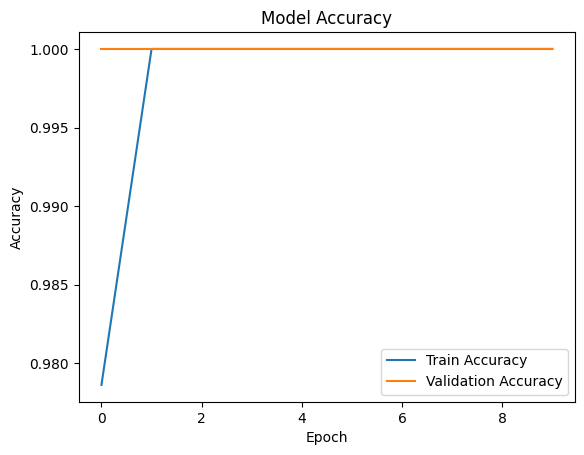

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()


In [ ]:
D#history = model_unified.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_test, y_test))
#history = model_unified.fit(X_train, y_train, epochs=20)

In [33]:
#loss, accuracy = model.evaluate(X_test, y_test)
#print(f"Unified Model - Test Accuracy: {accuracy:.2f}")

In [34]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score, classification_report

In [35]:
predictions = model.predict(X_test)

36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


In [36]:
predictions = np.argmax(predictions, axis=-1)

In [37]:
print("Accuracy : ", accuracy_score(y_test, predictions))
print("F1 score : ", f1_score(y_test, predictions, average='weighted'))
print("classification rapport : \n ", classification_report(y_test, predictions))

InvalidParameterError: The 'y_pred' parameter of accuracy_score must be an array-like or a sparse matrix. Got 0 instead.

36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


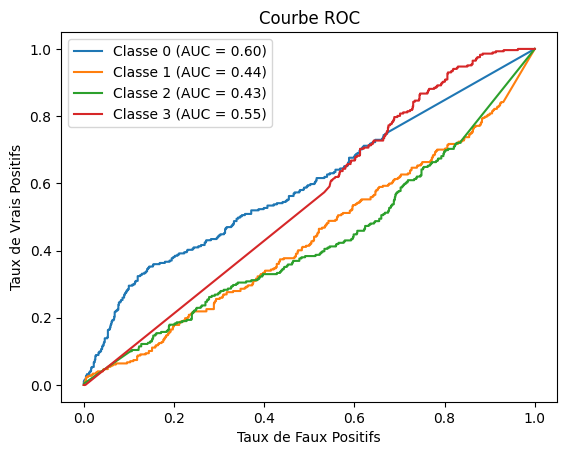

In [38]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_prob = model_unified.predict(X_test)  # Probabilités des prédictions
n_classes = len(np.unique(y_test))

# Binariser les labels pour ROC-AUC
from sklearn.preprocessing import label_binarize
y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))

# Calcul des courbes ROC
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Classe {i} (AUC = {roc_auc:.2f})")

plt.xlabel("Taux de Faux Positifs")
plt.ylabel("Taux de Vrais Positifs")
plt.title("Courbe ROC")
plt.legend()
plt.show()


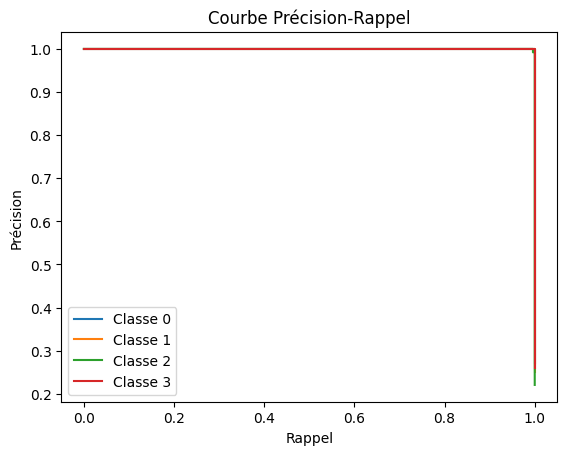

In [ ]:
from sklearn.metrics import precision_recall_curve

for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_prob[:, i])
    plt.plot(recall, precision, label=f"Classe {i}")

plt.xlabel("Rappel")
plt.ylabel("Précision")
plt.title("Courbe Précision-Rappel")
plt.legend()
plt.show()


In [ ]:
from sklearn.model_selection import KFold, cross_val_score

# Supposons que X et y soient tes données et tes labels respectifs
kf = KFold(n_splits=5)
model = ...  # Défini ton modèle ici

scores = cross_val_score(model, X, y, cv=kf, scoring='accuracy')
print("Scores de validation croisée :", scores)
print("Précision moyenne :", scores.mean())


In [ ]:
# Architecture multi-modale : données séparées
X_ips = segmented_dataIps.drop(columns=['categorie', 'id']).values
X_imu = segmented_dataImu.drop(columns=['categorie', 'id']).values
X_emg = segmented_dataEmg.drop(columns=['categorie', 'id']).values
y_multimodal = segmented_dataEmg['categorie'].values

# Séparer les données en train/test pour les deux architectures
X_unified_train, X_unified_test, y_unified_train, y_unified_test = train_test_split(X_unified, y_unified, test_size=0.2, random_state=42)

X_ips_train, X_ips_test, y_ips_train, y_ips_test = train_test_split(X_ips, y_multimodal, test_size=0.2, random_state=42)
X_imu_train, X_imu_test, y_imu_train, y_imu_test = train_test_split(X_imu, y_multimodal, test_size=0.2, random_state=42)
X_emg_train, X_emg_test, y_emg_train, y_emg_test = train_test_split(X_emg, y_multimodal, test_size=0.2, random_state=42)

In [ ]:
print("Forme des données unifiées :", X_unified.shape)
print("Forme des données IPS :", X_ips.shape)
print("Forme des données IMU :", X_imu.shape)
print("Forme des données EMG :", X_emg.shape)


NameError: name 'X_unified' is not defined

'def align_data_to_median(modalities):\n\n  # Obtenir le nombre de fenêtres pour chaque modalité\n  window_counts = [modality.shape[0] for modality in modalities]\n  # Calculer la médiane des nombres de fenêtres\n  median_windows = int(np.median(window_counts))\n  print(f"Médiane des fenêtres : {median_windows}")\n\n  aligned_modalities = []\n  for modality in modalities:\n      num_windows = modality.shape[0]\n      if num_windows > median_windows:\n          # Tronquer si le nombre de fenêtres est supérieur à la médiane\n          aligned_modality = modality[:median_windows]\n      elif num_windows < median_windows:\n          # Compléter si le nombre de fenêtres est inférieur à la médiane\n          padding_needed = median_windows - num_windows\n          # Répéter les dernières fenêtres pour compléter\n          padding = np.tile(modality[-1:], (padding_needed, 1, 1))\n          aligned_modality = np.concatenate([modality, padding], axis=0)\n      else:\n          # Pas de changeme

In [ ]:
"""# Données segmentées
modalities = [segmented_dataImu, segmented_dataEmg, segmented_dataIps]

# Aligner les données à la médiane
aligned_modalities = align_data_to_median(modalities)

# Vérifier les dimensions après alignement
for i, aligned_modality in enumerate(aligned_modalities):
    print(f"Modalité {i + 1} après alignement : {aligned_modality.shape}")

"""

In [ ]:
"""merged_results = []

for participant_id in normalized_dataEmg['id'].unique():
    emg_participant = normalized_dataEmg[normalized_dataEmg['id'] == participant_id]
    imu_participant = normalized_dataImu[normalized_dataImu['id'] == participant_id]
    ips_participant = normalized_dataIps[normalized_dataIps['id'] == participant_id]

    # Fusionner pour le participant actuel
    merged_participant = merge_modalities(emg_participant, imu_participant, ips_participant)

    # Sauvegarder les résultats pour éviter de surcharger la RAM
    merged_results.append(merged_participant)

    # Optionnel : Sauvegarder temporairement sur disque pour libérer de la mémoire
    merged_participant.to_csv(f"merged_participant_{participant_id}.csv", index=False)
"""

In [ ]:
"""1 -> back -> ips_1.csv , emg_1.csv, imu_1.csv
1 -> forward -> ips_1.csv , emg_1.csv, imu_1.csv
1 -> halfsquat -> ips_1.csv , emg_1.csv, imu_1.csv
1 -> still -> ips_1.csv , emg_1.csv, imu_1.csv
2 -> back -> ips_1.csv , emg_1.csv, imu_1.csv
2 -> forward -> ips_1.csv , emg_1.csv, imu_1.csv
2 -> halfsquat -> ips_1.csv , emg_1.csv, imu_1.csv
2 -> still -> ips_1.csv , emg_1.csv, imu_1.csv
3 -> back -> ips_1.csv , emg_1.csv, imu_1.csv
3 -> forward -> ips_1.csv , emg_1.csv, imu_1.csv
3 -> halfsquat -> ips_1.csv , emg_1.csv, imu_1.csv
3 -> still -> ips_1.csv , emg_1.csv, imu_1.csv
...
25 -> back -> ips_1.csv , emg_1.csv, imu_1.csv
25 -> forward -> ips_1.csv , emg_1.csv, imu_1.csv
25 -> halfsquat -> ips_1.csv , emg_1.csv, imu_1.csv
25 -> still -> ips_1.csv , emg_1.csv, imu_1.csv"""
